The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.0-alpha0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 92 kB 629 kB/s 


# Neural Style Transfer

사진 찍는 걸 좋아하신다면 필터에 익숙할 겁니다. 풍경 사진(landscape photo)이 더 선명해지거나 셀카의 피부를 더 뽀샤시하게 color 스타일을 바꿀 수 있습니다. 그러나 필터 하나는 사진의 한 측면만 변경합니다. 사진에 ideal한 스타일을 적용하려면 여러가지 필터를 조합시켜 사용해야 합니다. 이 Process는 모델의 hyperparameter들을 조정하는 것만큼 복잡합니다.

이 섹션에서는 CNN의 레이어별 표현을 활용하여 한 이미지의 스타일을 다른 이미지(의 스타일)에 자동으로 적용하는 **style transfer**[[Gatys et al., 2016](https://ieeexplore.ieee.org/document/7780634)]를 사용해볼겁니다. 해보기 위해서 두 가지 이미지가 필요합니다. **콘텐츠 이미지**와 **스타일 이미지**입니다. 신경망을 사용해서 콘텐츠 이미지를 스타일 이미지에 가깝게 수정할 것입니다. `fig_style_transfer`에서 콘텐츠 이미지는 시애틀의 레이니어 국립공원에서 촬영한 풍경 사진이고 스타일 이미지는 가을의 떡갈나무를 주제로 한 유화입니다. 출력된 Synthesized image에서 스타일 이미지의 유화 기법이 적용된 콘텐츠 이미지를 볼 수 있습니다. 주요 모양을 유지하며 더 선명한 색상으로 이어집니다. 

![Given content and style images, style transfer outputs a synthesized image.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/style-transfer.svg?raw=1)  
`fig_style_transfer`

## Method

`fig_style_transfer_model`은 CNN 기반 Style transfer를 예시와 함께 보여줍니다. 첫 번째로, 예를 들어 합성된 이미지(Synthesized image)를 콘텐츠 이미지로 만듭니다(초기화). 합성된 이미지는 style transfer 과정에서 유일한 변수, 즉, 학습동안 업데이트해야 하는 파라미터입니다.

그런 다음, 이미지 feature들을 추출하고 훈련 중에 모델 파라미터들을 고정하기 위해 pretrained CNN을 선택합니다. 이러한 심층 CNN은 이미지에 대한 계층적(hierarchical) feature들을 추출하기 위해 여러 레이어들을 사용합니다. `fig_style_transfer_model`를 보면, pretrained CNN에는 3개의 convolutional 레이어가 있으며 첫 번째, 세 번째 레이어는 **스타일 feature**를, 두 번째 레이어는 **콘텐츠 feature**를 출력합니다. 

![CNN-based style transfer process. Solid lines show the direction of forward propagation and dotted lines show backward propagation. ](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/neural-style.svg?raw=1)
`fig_style_transfer_model`

다음으로, forward propagation(실체 화살표 방향)를 통해 style transfer의 손실 함수를 계산하고, backpropagation(파선 화살표 방향)를 통해 모델 파라미터(출력을 위한 합성 이미지)를 업데이트합니다. style transfer에서 일반적으로 사용되는 손실 함수는 세 부분으로 구성됩니다. 

1. **Content loss**은 합성 이미지와 콘텐츠 이미지를 콘텐츠 feature에서 가깝게 만듭니다.   
2. **Style loss**은 합성 이미지와 스타일 이미지를 스타일 feature에서 가깝게 만듭니다.   
3. **Total variation loss**은 합성 이미지의 노이즈를 줄이는 데 도움이 됩니다. 

마지막으로 모델 학습이 끝나면 style transfer의 모델 파라미터를 출력하여 최종 합성 이미지를 생성합니다. 아래에서는 구체적인 실험을 통해 style transfer에 대한 기술적 세부 사항을 설명할 것입니다.

## **Reading the Content and Style Images**

먼저, 컨텐츠 이미지와 스타일 이미지를 읽어옵니다. 프린트된 좌표축을 보면 이 이미지들이 서로 다른 크기를 가지고 있다는 것을 알 수 있습니다.


In [ ]:
import urllib.request
url = "https://raw.githubusercontent.com/d2l-ai/d2l-en/master/img/rainier.jpg"
urllib.request.urlretrieve(url, '/content/sample_data/rainier.jpg')

('/content/sample_data/rainier.jpg',
 <http.client.HTTPMessage at 0x7f536daacf50>)

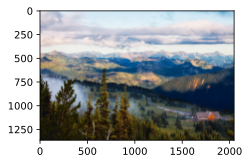

In [ ]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

d2l.set_figsize()
content_img = d2l.Image.open('/content/sample_data/rainier.jpg')
d2l.plt.imshow(content_img);

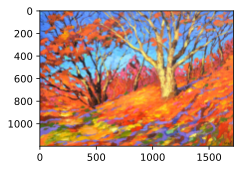

In [ ]:
url = "https://raw.githubusercontent.com/d2l-ai/d2l-en/master/img/autumn-oak.jpg"
urllib.request.urlretrieve(url, '/content/sample_data/autumn-oak.jpg')
style_img = d2l.Image.open('/content/sample_data/autumn-oak.jpg')
d2l.plt.imshow(style_img);

## **Preprocessing and Postprocessing**

아래에서는 영상 전처리 및 후처리를 위한 두 가지 함수를 정의합니다. 전처리 함수`preprocess`는 입력 이미지의 3개의 RGB 채널 각각을 표준화하고 결과를 CNN 입력 형식으로 변환합니다. 후처리 함수 `postprocess`는 출력 영상의 픽셀 값을 표준화 전의 원래 값으로 복원합니다. 이미지 프린팅 함수는 각 픽셀의 부동소수점 값(floating point value)이 0과 1사이여야 하므로 0보다 작거나 1보다 큰 값을 각각 0 또는 1로 바꿔줍니다.

In [ ]:
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])

def preprocess(img, image_shape):
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_shape),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)])
    # unsqueeze(dim): 입력한 차원값에 1인 차원을 생성해줌
    return transforms(img).unsqueeze(0)

def postprocess(img):
    img = img[0].to(rgb_std.device)
    # torch.clamp(input, min, max): 
    # min이나 max값을 설정하고 그 값에 미달하는 값을 설정한 값으로 바꿔줌
    # ex) min=0.5 일경우 0.5이하의 값은 0.5로 바뀜
    # permute(): tensor 안의 index를 입력한 순서로 바꿔줌
    img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1)
    # ToPILImage(): Pytorch Image Tensor를 PIL 이미지(numpy 배열)로 바꿔줌
    return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))

```
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])
```
[mean, std에 위 값을 사용하는 이유](https://stackoverflow.com/questions/58151507/why-pytorch-officially-use-mean-0-485-0-456-0-406-and-std-0-229-0-224-0-2): pretraining에 사용된 ImageNet 데이터셋의 학습 시에 얻어낸 값

## **Extracting Features**

이미지 기능을 추출하기 위해 ImageNet 데이터셋에서 pretrained VGG-19 모델을 사용합니다. [[Gatys et al., 2016](https://ieeexplore.ieee.org/document/7780634)]


In [ ]:
pretrained_net = torchvision.models.vgg19(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

이미지의 콘텐츠 feature와 스타일 feature를 추출하기 위해 VGG 네트워크에서 특정 레이어의 출력을 선택할 수 있습니다. 일반적으로 입력 레이어에 가까울수록 이미지의 세부 정보를 추출하기 쉽고, 멀어질수록 이미지의 Global 정보를 추출하기 쉽습니다. 합성 이미지에서 콘텐츠 이미지의 세부 정보가 과도하게 유지되는 것을 피하기 위해 콘텐츠 레이어(이미지의 콘텐츠 함수를 출력)로 출력에 더 가까운 VGG 레이어를 선택합니다. 또한 로컬과 글로벌 스타일 feature를 추출하기 위해 다른 VGG 레이어의 출력을 선택합니다.

이러한 레이어를 스타일 레이어라고도 합니다. **섹션 8.2 Networks Using Blocks (VGG)**에서 언급했듯이, VGG 네트워크는 5개의 컨볼루션 블록을 사용합니다. 실험에서, 네 번째 컨볼루션 블록의 마지막 컨볼루션 레이어를 콘텐츠 레이어로, 각 컨볼루션 블록의 첫 번째 컨볼루션 레이어를 스타일 레이어로 선택합니다. 이러한 레이어의 인덱스는 `pretrained_net` 인스턴스를 프린트하여 얻을 수 있습니다.

### Style transfer algorithm 🔧
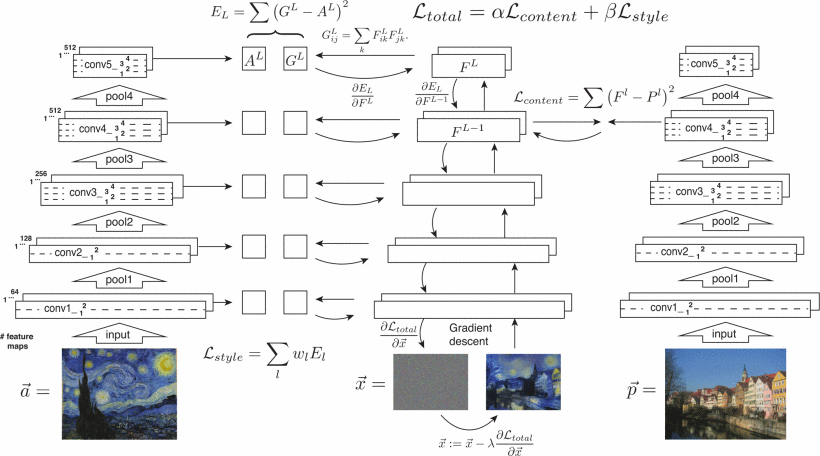

In [ ]:
# 각 컨볼루션 블록의 첫 번째 컨볼루션 레이어를 스타일 레이어
# 네 번째 컨볼루션 블록의 마지막 컨볼루션 레이어를 콘텐츠 레이어
style_layers, content_layers = [0, 5, 10, 19, 28], [25]
# print(pretrained_net)

VGG 레이어를 사용하여 feature를 추출할 때는 입력 레이어에서 출력 레이어에 가장 가까운 콘텐츠 레이어 또는 스타일 레이어에 이르는 모든 feature들을 사용하면 됩니다. feature 추출에 사용될 모든 VGG 레이어만 유지하는 새로운 네트워크 인스턴스 `net`을 구축해봅시다.



In [ ]:
net = nn.Sequential(*[pretrained_net.features[i] for i in
                      range(max(content_layers + style_layers) + 1)])

In [ ]:
range(max(content_layers + style_layers) + 1)
# pretrained_net.features[0:29]

range(0, 29)

입력 `X`가 주어지면 forward propagation `net(X)`을 호출하여 마지막 레이어의 출력값을 얻을 수 있습니다. 중간 레이어의 출력값도 필요하기 때문에 레이어 단위 계산을 수행하고 콘텐츠 레이어와 스타일 레이어의 출력값을 유지해야 합니다.

In [ ]:
def extract_features(X, content_layers, style_layers):
    # 콘텐츠와 스타일 출력값 저장을 위해 리스트 생성
    contents = []
    styles = []
    # 레이어 단위 계산
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles

`get_contents` 함수는 콘텐츠 이미지에서 콘텐츠 feature를 추출하고 `get_styles` 함수는 스타일 이미지에서 스타일 feature를 추출합니다. 학습 중에 사전학습된 VGG의 모델 파라미터를 업데이트할 필요가 없기 때문에 학습이 시작되기 전에도 콘텐츠와 스타일의 feature를 추출할 수 있습니다. 합성된 이미지는 style transfer를 위해 업데이트되는 모델 파라미터들의 집합이기 때문에, 학습 중에 `extract_features` 함수를 호출하여 합성된 이미지의 내용과 스타일 feature를 따로 추출할 수 있습니다.

In [ ]:
def get_contents(image_shape, device):
    content_X = preprocess(content_img, image_shape).to(device)
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y

def get_styles(image_shape, device):
    style_X = preprocess(style_img, image_shape).to(device)
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y

## **Defining the Loss Function**

이제 style transfer를 위한 손실 함수에 대해 설명하겠습니다. 손실 함수는 content loss, style loss, and total variation loss로 구성됩니다.

### Content Loss

선형 회귀의 손실 함수와 비슷하게 콘텐츠 loss는 squared loss function을 통해 합성 이미지와 콘텐츠 이미지 간의 콘텐츠 feature 차이를 측정합니다. squared loss function의 두 입력은 `extract_features` 함수에 의해 계산된 콘텐츠 레이어의 output입니다.


In [ ]:
def content_loss(Y_hat, Y):
    # We detach the target content from the tree used to dynamically compute 
    return torch.square(Y_hat - Y.detach()).mean()
    # detach() : 기존 Tensor에서 gradient 전파가 안되는 텐서 생성 
    # gradient: 이것은 변수가 아닌 명시된 값입니다. 그렇지 않으면 loss에서 error가 나오게 됩니다.

### Style Loss

스타일 loss는 콘텐츠 loss와 유사하게 제곱 손실 함수(squared loss function)를 사용하여 합성 이미지와 스타일 이미지 간의 스타일 차이를 측정합니다. 모든 스타일 레이어의 스타일 출력을 표현하기 위해 먼저 extract_features 함수를 사용하여 스타일 레이어의 출력값을 계산합니다.

출력에 채널 $c$, 높이 $h$ 및 너비 $w$가 있다고 가정하면이 출력을 $c$ 행, $hw$ 열이 있는 행렬 $\mathbf{X}$로 변환할 수 있습니다. 이 행렬은 $c$ 벡터 $\mathbf{x}_1, \ldots, \mathbf{x}_c$의 연결로 생각할 수 있습니다. 각 벡터의 길이는 $hw$입니다. 여기서, 벡터 $\mathbf{x}_i$는 채널 $i$의 스타일 feature를 나타냅니다.

벡터 $\mathbf{X}\mathbf{X}^\top \in \mathbb{R}^{c \times c}$의 *Gram matrix*에서 행 $i$와 열 $j$의 원소 $x_{ij}$는 벡터 $\mathbf{x}_i$와 $\mathbf{x}_j$의 내적입니다. 이 원소는 채널 $i$와 $j$의 스타일 feature의 상관 관계를 나타냅니다. 이 Gram 매트릭스를 사용하여 모든 스타일 레이어의 스타일 output을 나타냅니다. $hw$ 값이 클수록 Gram 행렬의 값이 커질 수 있습니다. 또한 그램 행렬의 높이와 너비는 모두 채널의 수인 $c$입니다. 스타일 loss가 이러한 값의 영향을받지 않도록하기 위해 아래의 그램 함수는 그램 행렬을 원소의 수, 즉 $chw$로 나눕니다.


In [ ]:
def gram(X):
    # c, hw(=chw/c)
    # numel(): tensor의 원소의 수를 반환
    num_channels, n = X.shape[1], X.numel() // X.shape[1]
    X = X.reshape((num_channels, n))
    # matmul(): 두 배열의 행렬 곱
    return torch.matmul(X, X.T) / (num_channels * n)

스타일 loss에 대한 squared loss function의 두 가지 Gram 행렬의 input은 합성 이미지와 스타일 이미지에 대한 스타일 레이어의 output에 기초합니다. 여기서는 스타일 이미지에 기반한 Gram 행렬 `gram_Y`가 사전 계산되었다고 가정합니다.

In [ ]:
def style_loss(Y_hat, gram_Y):
    return torch.square(gram(Y_hat) - gram_Y.detach()).mean()

### Total Variation Loss

때로는 학습된 합성 이미지가 고주파 노이즈(high-frequency noise)를 (특히 밝거나 어두운 픽셀일때) 많이 갖습니다. 일반적인 디노이징 방법은 **total variation denoising**입니다. 좌표 $(i, j)$에서 픽셀 값을 $x_{i, j}$로 나타냅니다.

$$\sum_{i, j} \left|x_{i, j} - x_{i+1, j}\right| + \left|x_{i, j} - x_{i, j+1}\right|$$

Total variation loss의 감소가 합성 이미지에서 인접 픽셀들의 값을 더 가깝게 만듭니다.

In [ ]:
def tv_loss(Y_hat):
    # |𝑥𝑖,𝑗−𝑥𝑖+1,𝑗|.mean() + ∣𝑥𝑖,𝑗−𝑥𝑖,𝑗+1∣.mean()
    return 0.5 * (torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
                  torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

In [ ]:
# import numpy as np
# k = np.array([[[0,1,2], 
#                [1,2,3], 
#                [2,3,4]], 
              
#               [[1,1,1], 
#                [2,2,2], 
#                [3,3,3]]])
# print(k[:, 1:, :])
# print(k[:, :-1, :])
# print((k[:, 1:, :] + k[:, :-1, :]).mean())
# print(k[:, :, 1:])
# print(k[:, :, :-1])
# print((k[:, :, 1:] + k[:, :, :-1]).mean())

### Loss Function

**style transfer의 손실 함수는 content loss, style loss, and total variation loss의 가중 합입니다.** 이러한 weight hyperparameter들을 조정함으로써 합성 이미지의 콘텐츠 보존, 스타일 transfer 및 노이즈 감소 간의 균형을 맞출 수 있습니다.



In [ ]:
content_weight, style_weight, tv_weight = 1, 1e3, 10

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    # content, style, and total variance loss을 각각 계산합니다.
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
        contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
        styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    # Add up all the losses
    l = sum(10 * styles_l + contents_l + [tv_l])
    return contents_l, styles_l, tv_l, l

## **Initializing the Synthesized Image**

Style transfer에서 합성된 이미지는 학습 중에 업데이트를 해야하는 유일한 변수입니다. 따라서 우리는 간단한 모델인 `SynthesizedImage`를 정의하고 합성된 이미지를 모델 파라미터로 취급할 수 있습니다. 이 모형에서 순방향 전파(forward propagation)는 모형 파리미터만 반환합니다.


In [ ]:
class SynthesizedImage(nn.Module):
    def __init__(self, img_shape, **kwargs):
        super(SynthesizedImage, self).__init__(**kwargs)
        self.weight = nn.Parameter(torch.rand(*img_shape))

    def forward(self):
        return self.weight

다음으로 `get_inits`의 함수를 정의합니다. 이 함수는 합성 이미지 모델의 인스턴스를 생성하여 이미지 `X`로 초기화합니다. `styles_Y_gram`에서는 스타일 레이어들의 스타일 이미지에 대한 그램 행렬이 학습 전에 계산됩니다.


In [ ]:
def get_inits(X, device, lr, styles_Y):
    gen_img = SynthesizedImage(X.shape).to(device)
    gen_img.weight.data.copy_(X.data)
    trainer = torch.optim.Adam(gen_img.parameters(), lr=lr)
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer

## **Training**

Style transfer를 위한 모델을 학습할 때, 우리는 합성 이미지의 콘텐츠 feature와 스타일 feature를 지속적으로 추출하고 손실 함수를 계산합니다. 다음은 학습 루프를 정의합니다.


In [ ]:
def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch, 0.8)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs],
                            legend=['content', 'style', 'TV'],
                            ncols=2, figsize=(7, 2.5))
    # epoch: feature 추출, loss 계산, 역전파
    for epoch in range(num_epochs):
        trainer.zero_grad()
        contents_Y_hat, styles_Y_hat = extract_features(
            X, content_layers, style_layers)
        contents_l, styles_l, tv_l, l = compute_loss(
            X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        l.backward()
        trainer.step()
        scheduler.step()
        # 실시간 시각화
        if (epoch + 1) % 10 == 0:
            animator.axes[1].imshow(postprocess(X))
            animator.add(epoch + 1, [float(sum(contents_l)),
                                     float(sum(styles_l)), float(tv_l)])
    return X

이제 **모델을 훈련하기 시작**합니다. 콘텐츠 및 스타일 이미지의 높이와 너비를 300 x 450 픽셀로 재조정합니다. 우리는 합성된 이미지를 초기화하기 위해 콘텐츠 이미지를 사용합니다.


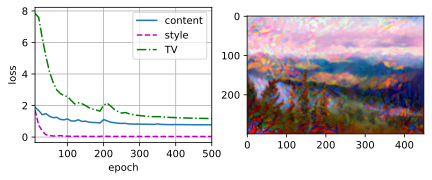

In [ ]:
device, image_shape = d2l.try_gpu(), (300, 450)  # PIL Image (h, w)
net = net.to(device)
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.3, 500, 50)

합성된 이미지가 콘텐츠 이미지의 풍경과 사물을 그대로 유지하면서 스타일 이미지의 색상을 동시에 전달하는 것을 볼 수 있습니다. 예를 들어, 합성된 이미지는 스타일 이미지에 있는 것과 같은 색상 블록을 가지고 있습니다. 이 블록들 중 일부는 심지어 붓놀림의 미묘한 질감(texture of brush strokes)을 가지고 있습니다.




## Summary

* Style transfer에서 일반적으로 사용되는 손실 함수는 세 부분으로 구성됩니다.    
  1. 콘텐츠 loss는 합성 이미지와 콘텐츠 이미지를 콘텐츠 feature에 가깝게 만듭니다.     
  2. 스타일 loss는 합성 이미지와 스타일 이미지를 스타일 feature에 가깝게 만듭니다.    
  3. 총 변동 loss는 합성 이미지의 노이즈를 줄이는 데 도움이 됩니다.

* Pretrained CNN을 사용하여 이미지 feature들을 추출하고 손실 함수를 최소화하여 학습 중에 합성된 이미지를 모델 파라미터로 지속적인 업데이트를 할 수 있습니다.

* 그램 행렬을 사용하여 스타일 레이어의 스타일 output을 나타냅니다.


## Exercises

1. How does the output change when you select different content and style layers?
1. Adjust the weight hyperparameters in the loss function. Does the output retain more content or have less noise?
1. Use different content and style images. Can you create more interesting synthesized images?
1. Can we apply style transfer for text? Hint: you may refer to the survey paper by Hu et al. :cite:`Hu.Lee.Aggarwal.ea.2020`.


[Discussions](https://discuss.d2l.ai/t/1476)


# Image Classification (CIFAR-10) on Kaggle
`sec_kaggle_cifar10`

지금까지, 이미지 데이터셋을 텐서 형식으로 직접 얻기 위해 딥러닝 프레임워크의 High-Level API를 사용해 왔습니다. 그러나 사용자 지정 이미지 데이터셋은 이미지 파일 형태로 제공되는 경우가 많습니다. 이 섹션에서는 raw 이미지 파일에서 시작하여 이를 정리하고 읽어온 다음, 단계별 텐서 형식으로 변환합니다.

섹션 14.1 `sec_image_augmentation`에서 컴퓨터 비전의 중요한 데이터셋인 CIFAR-10 데이터 세트를 실험했습니다. 이 섹션에서는 CIFAR-10 이미지 분류의 Kaggle 대회를 연습하기 위해 이전 섹션에서 배운 지식을 적용할 것입니다. (대회의 웹 주소는 https://www.kaggle.com/c/cifar-10 입니다.)

`fig_kaggle_cifar10`은 대회의 웹 페이지에 있는 정보를 보여줍니다. 결과를 제출하기 위해서는 Kaggle 계정을 등록해야 합니다.


![CIFAR-10 image classification competition webpage information. The competition dataset can be obtained by clicking the "Data" tab.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/kaggle-cifar10.png?raw=1)`fig_kaggle_cifar10`


## Kaggle? 🔧

캐글(Kaggle)은 2010년 설립된 예측모델 및 분석 대회 플랫폼이다. 기업 및 단체에서 데이터와 해결과제를 등록하면, 데이터 과학자들이 이를 해결하는 모델을 개발하고 경쟁한다. [2017년 3월 구글에 인수되었다.](https://www.ciokorea.com/news/33510)

Kaggle의 대표적인 data set: Titanic

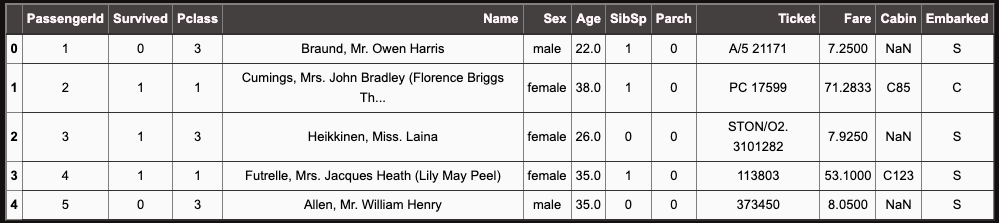


In [ ]:
import collections
import math
import os
import shutil
import pandas as pd
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

## Obtaining and Organizing the Dataset

대회의 데이터셋은 학습 세트와 테스트 세트로 나뉘며, 각각 50000개와 300000개의 이미지를 가지고 있습니다. 테스트 세트에서 10000개의 이미지는 평가에 사용되는 반면 나머지 290000개의 이미지는 평가되지 않고 *테스트 세트의 레이블이 **manually**하게 지정하는 부정행위*를 막기 위해 포함됩니다. 이 데이터 세트의 이미지는 높이와 폭이 모두 32픽셀인 컬러(RGB 채널) 이미지 png 파일입니다.  이미지들은 비행기, 자동차, 새, 고양이, 사슴, 개, 개구리, 말, 보트, 트럭 등 총 10개의 카테고리를 가지고 있습니다. 그림 `fig_kaggle_cifar10`의 왼쪽 상단 모서리는 데이터 세트에서 비행기, 자동차, 새의 일부 이미지를 보여줍니다.

### Downloading the Dataset

Kaggle에 로그인한 후, 그림 `fig_kaggle_cifar10`처럼 CIFAR-10 이미지 분류 경쟁 웹 페이지에서 "Data" 탭을 클릭합니다. 그리고 "Download All" 버튼을 클릭하여 데이터 세트를 다운로드합니다. 다운로드한 파일을 `../data`에 압축을 풀고 `train.7z`와 `test.7z`를 내부에서 압축을 풉니다. 전체 데이터 세트 경로: 
* `../data/cifar-10/train/[1-50000].png`
* `../data/cifar-10/test/[1-300000].png`
* `../data/cifar-10/trainLabels.csv`
* `../data/cifar-10/sampleSubmission.csv`

여기서 `train`과 `test`디렉토리는 각각 학습 및 테스트 이미지를 포함하고 `trainLabels.csv`는 학습 이미지에 대한 레이블을 제공하며 `sample_submission.csv`는 샘플 제출 파일입니다.

쉽게 시작할 수 있도록 **처음 1000개의 학습 이미지와 무작위 테스트 이미지 5개가 포함된 데이터 세트의 소규모 샘플을 제공합니다**. Kaggle 대회의 전체 데이터 세트를 사용하려면 `demo`변수를 `False`로 설정해야 합니다.



In [ ]:
d2l.DATA_HUB['cifar10_tiny'] = (d2l.DATA_URL + 'kaggle_cifar10_tiny.zip',
                                '2068874e4b9a9f0fb07ebe0ad2b29754449ccacd')

# Kaggle 대회의 전체 데이터 세트를 사용하려면 demo변수를 False로 설정해야 합니다.
demo = True

if demo:
    data_dir = d2l.download_extract('cifar10_tiny')
else:
    data_dir = '../data/cifar-10/'

### **Organizing the Dataset**

모델의 학습과 테스트를 데이터 세트를 구성할 필요가 있습니다. 먼저 csv파일에서 레이블을 읽어 옵니다. 아래의 함수는 파일 이름의 비확장(non-extension) 부분을 레이블에 매핑하는 딕셔너리를 반환합니다.

In [ ]:
def read_csv_labels(fname):
    """레이블 딕셔너리에 파일 이름을 반환하기위해 'fname'을 Read"""
    with open(fname, 'r') as f:
        # f.readlines()[1:]: 열 이름을 생략 
        lines = f.readlines()[1:]
    tokens = [l.rstrip().split(',') for l in lines]
    return dict(((name, label) for name, label in tokens))

labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
# 성공적으로 읽어왔다면 examples: 1000개, classes: 10개
print('# training examples:', len(labels))
print('# classes:', len(set(labels.values())))

# training examples: 1000
# classes: 10


다음으로, `reorg_train_valid` 함수를 정의하여 **검증 세트를 원래 학습 세트에서 분할**합니다. 이 함수의 인수 `valid_ratio`는 검증 집합에 있는 example 수와 원래 학습 집합에 있는 example 수의 비율입니다. 보다 구체적으로, $n$은 가장 적은 example을 가진 클래스의 이미지 수이고, $r$은 비율입니다. 검증 세트는 각 클래스에 대해 $\max(\lfloor nr\rfloor,1)$을 분할합니다. `valid_ratio=0.1`로 예를 들어 보겠습니다. 원래 학습 세트의 이미지는 50000개이므로, `train_valid_test/train`경로에서 학습에 사용되는 이미지는 45000개이고, 나머지 5000개 이미지는 `train_valid_test/valid`경로에서 검증 세트로 분할됩니다. 데이터 세트를 구성한 후에는 동일한 클래스의 이미지가 동일한 폴더 아래에 배치됩니다.



In [ ]:
def copyfile(filename, target_dir):
    """파일을 대상 디렉터리에 복사합니다."""
    os.makedirs(target_dir, exist_ok=True)
    shutil.copy(filename, target_dir)

def reorg_train_valid(data_dir, labels, valid_ratio):
    """검증 세트를 원래 학습 세트에서 분할합니다."""
    # 학습 데이터 세트에서 example이 가장 적은 클래스의 이미지 수
    # collections.Counter(): 중복되는 원소들의 개수를 세고 딕셔너리 형태로 반환
    # Counter().most_common(): 개수가 많은 순서로 sort 해줌
    n = collections.Counter(labels.values()).most_common()[-1][1]
    # 검증 집합에 대한 클래스당 example 수, 위에서의 max(⌊𝑛𝑟⌋,1)
    # math.floor: 실수를 입력하면 내림하여 정수를 반환
    n_valid_per_label = max(1, math.floor(n * valid_ratio))
    label_count = {}
    for train_file in os.listdir(os.path.join(data_dir, 'train')):
        label = labels[train_file.split('.')[0]]
        fname = os.path.join(data_dir, 'train', train_file)
        copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                     'train_valid', label))
        if label not in label_count or label_count[label] < n_valid_per_label:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                         'valid', label))
            label_count[label] = label_count.get(label, 0) + 1
        else:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                         'train', label))
    return n_valid_per_label

아래의 `reorg_test` 함수는 **예측 중 데이터 로딩을 위한 테스트 세트를 구성**합니다.


In [ ]:
def reorg_test(data_dir):
    """예측 중 데이터 로드를 위한 테스트 세트를 구성합니다."""
    for test_file in os.listdir(os.path.join(data_dir, 'test')):
        copyfile(os.path.join(data_dir, 'test', test_file),
                 os.path.join(data_dir, 'train_valid_test', 'test',
                              'unknown'))

마지막으로 함수를 **사용**하여 **위에 정의된 함수**`reorg_csv_labels`, `reorg_train_valid` 및 `reorg_test`를 호출합니다.



In [ ]:
def reorg_cifar10_data(data_dir, valid_ratio):
    labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
    reorg_train_valid(data_dir, labels, valid_ratio)
    reorg_test(data_dir)

여기서는 데이터 세트의 소규모(small-scale) 샘플에 대한 배치 크기만 32로 설정한다. Kaggle 대회의 전체 데이터 세트를 학습하고 테스트할 때, `batch_size`는 128과 같은 더 큰 정수로 설정해야 합니다. hyperparameter들을 조정하기 위한 검증 세트로 학습 예제의 10%를 분할합니다.

In [ ]:
# 전체 데이터를 사용(demo = False)할 때는 batch_size를 128로 사용
batch_size = 32 if demo else 128
valid_ratio = 0.1
reorg_cifar10_data(data_dir, valid_ratio)

## **Image Augmentation**

과적합을 해결하기 위해 이미지 어그멘테이션(image augmentation)를 사용합니다. 예를 들어, 학습 중에 이미지를 무작위로 수평으로 뒤집는다거나, 컬러 이미지의 RGB 채널 3개에 대한 표준화시키는 방법이 있습니다. 아래에 조정법 몇 가지가 있습니다.


### 정규화(Normalization)와 표준화(Standardization) 🔧

* 정규화(Normalization):   
  * 데이터를 특정 구간으로 바꾸는 척도법이다 (ex. 0&#126;1 or 0&#126;100).   
  * 식 : (측정값 - 최소값) / (최대값 - 최소값)
* 표준화(Standardization): 
    * 데이터를 0을 중심으로 양쪽으로 데이터를 분포시키는 방법이다.   
    * 표준화를 하게 되면 각 데이터들은 평균을 기준으로 얼마나 떨여져 있는지를 나타내는 값으로 변환된다.  
    * 식 (Z-score 표준화) : (측정값 - 평균) / 표준편차 

In [ ]:
transform_train = torchvision.transforms.Compose([
    # 높이와 너비 모두 40픽셀의 정사각형 이미지로 랜덤하게 자른 뒤, 
    torchvision.transforms.Resize(40),
    # 원본 이미지의 면적의 0.64~1.0배의 작은 정사각형을 생성하고,
    # 이후 높이와 너비 모두 32픽셀의 정사각형으로 스케일링
    torchvision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0),
                                                   ratio=(1.0, 1.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    # 이미지의 각 채널을 Standardize
    # Cifar-10의 표준화 값이기 때문에 이미지넷의 표준화 값과 다르다
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])])

테스트 중에는 검증 결과의 무작위성을 제거하기 위해 이미지에 대해서만 표준화를 수행합니다.



In [ ]:
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])])

## Reading the Dataset

다음으로, **raw 이미지 파일로 구성된 데이터 세트를 읽어옵니다.** 각 example은 이미지 및 라벨을 포함한다.



In [ ]:
train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_train) for folder in ['train', 'train_valid']]

valid_ds, test_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_test) for folder in ['valid', 'test']]

학습 중에, **위에서 정의한 모든 이미지 어그멘테이션 작업을 지정**해야 합니다. 하이퍼파라미터 조정 중 모델 검증에 검증 세트를 사용할 경우, 무작위성을 이미지 어그멘테이션에 도입해서는 안됩니다. 최종 예측 전에, 레이블이 지정된 모든 데이터를 최대한 활용할 수 있도록 combine된 훈련 세트와 검증 세트의모델을 학습합니다.

In [ ]:
train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                                         drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)

## Defining the **Model**


섹션 8.6 `sec_resnet`에 설명된 ResNet-18 모델을 정의합니다.


In [ ]:
def get_net():
    num_classes = 10
    net = d2l.resnet18(num_classes, 3)
    return net

loss = nn.CrossEntropyLoss(reduction="none")

## Defining the **Training Function**

검증 세트에서 모델의 성능에 따라 모델을 선택하고 하이퍼 파라미터를 조정할 것입니다. 모델 훈련 함수인 `train`을 정의합니다.

In [ ]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
          lr_decay):
    # optimizer: SGD
    trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9,
                              weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    # 시각화
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    # 병렬 연산 처리
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    # 학습
    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = d2l.train_batch_ch13(net, features, labels,
                                          loss, trainer, devices)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[2],
                              None))
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))
        scheduler.step()
    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')

## **Training and Validating the Model**

이제 모델을 학습하고 검증할 수 있습니다. 하이퍼 파라미터들을 조정할 수 있습니다. 예를 들어, 에포크 수를 늘릴 수 있습니다. `lr_period`와 `lr_decay`를 각각 4와 0.9로 설정하면 optimization 알고리즘의 학습률은 4 에포크마다 0.9를 곱하게 됩니다. 아래에선 시연하기 쉽도록, 20 epoch만 학습합니다.


train loss 0.573, train acc 0.816, valid acc 0.453
1045.7 examples/sec on [device(type='cuda', index=0)]


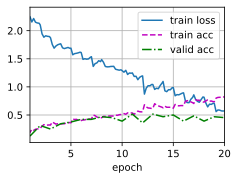

In [ ]:
# 학습률: 2e-4, 가중치 감소(weight decay): 5e-4
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 20, 2e-4, 5e-4
lr_period, lr_decay, net = 4, 0.9, get_net()
net(next(iter(train_iter))[0])
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

## **Classifying the Testing Set** and Submitting Results on Kaggle

하이퍼파라미터가 있는 좋은 모델을 얻은 후, 레이블링된 모든 데이터(검증 세트 포함)를 사용하여 모델을 재학습하고 테스트 세트를 분류시킵니다.


train loss 0.646, train acc 0.763
1057.7 examples/sec on [device(type='cuda', index=0)]


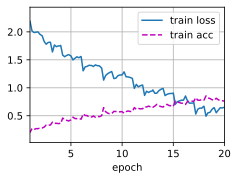

In [ ]:
net, preds = get_net(), []
net(next(iter(train_valid_iter))[0])
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

for X, _ in test_iter:
    y_hat = net(X.to(devices[0]))
    preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy())
sorted_ids = list(range(1, len(test_ds) + 1))
sorted_ids.sort(key=lambda x: str(x))
df = pd.DataFrame({'id': sorted_ids, 'label': preds})
df['label'] = df['label'].apply(lambda x: train_valid_ds.classes[x])
df.to_csv('submission.csv', index=False)

위의 코드는 `submission.csv` 파일을 생성하며, 이 형식은 Kaggle 대회의 요구사항을 충족합니다. 결과를 Kaggle에 제출하는 방법은 섹션 5.7`sec_kaggle_house`의 방법과 유사합니다.

## Summary

* raw 이미지 파일이 포함된 데이터 세트를 필요한 형식으로 구성한 후 읽어 올 수 있습니다.

* 우리는 image classification 대회에서 convolutional neural networks과 image augmentation을 사용할 수 있습니다.


## Exercises

1. Use the complete CIFAR-10 dataset for this Kaggle competition. Set hyperparameters as `batch_size = 128`, `num_epochs = 100`, `lr = 0.1`, `lr_period = 50`, and `lr_decay = 0.1`.  See what accuracy and ranking you can achieve in this competition. Can you further improve them?
1. What accuracy can you get when not using image augmentation?


[Discussions](https://discuss.d2l.ai/t/1479)


# Dog Breed Identification (ImageNet Dogs) on Kaggle

이 섹션에서는 Kaggle에 대한 견종 식별 문제를 연습할 것입니다. (**이 대회의 웹 주소는 https://www.kaggle.com/c/dog-breed-identification 입니다.**)

이번 대회에서는 120종의 다양한 견종을 분류합니다. 사실, 이 대회의 데이터 세트는 ImageNet 데이터 세트의 하위 집합입니다. 섹션 14.13 `sec_kaggle_cifar10`의 CIFAR-10 데이터 세트의 이미지와 달리 ImageNet 데이터 세트의 이미지는 넓이와 높이가 큰 다양한 차원을 가지고 있습니다. 그림 `fig_kaggle_dog`은 대회 사이트의 웹 페이지에 대한 정보를 보여줍니다. 결과를 제출하려면 Kaggle 계정이 필요합니다.

![The dog breed identification competition website. The competition dataset can be obtained by clicking the "Data" tab.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/kaggle-dog.jpg?raw=1)
`fig_kaggle_dog`


In [ ]:
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

## Obtaining and Organizing the Dataset

대회 데이터 세트는 학습 세트와 테스트 세트로 나뉘는데, 여기에는 각각 RGB(컬러) 채널 3개의 JPEG 이미지로 10,222(학습)개와 10,357(테스트)개로 구성되어있습니다. 훈련 데이터 세트 중에는 래브라도, 푸들, 닥스훈트, 사모예드, 허스키스, 치와와, 요크셔 테리어 등 120종의 개가 있다.

### Downloading the Dataset

Kaggle 로그인 후 그림 `fig_kaggle_dog`에 표시된 경쟁 웹페이지에서 "Data" 탭을 클릭하고 "Download All" 버튼을 클릭하여 데이터 세트를 다운로드할 수 있습니다. `../data`에서 다운로드한 파일의 압축을 풀면 다음 경로에 전체 데이터 세트가 있습니다.

* ../data/dog-breed-identification/labels.csv
* ../data/dog-breed-identification/sample_submission.csv
* ../data/dog-breed-identification/train
* ../data/dog-breed-identification/test

위의 구조는 섹션 14.13 `sec_kaggle_cifar10`의 CIFAR-10 대회와 유사합니다. 여기서 폴더는 `train/`와 `test/`에 개 이미지를 각각 저장하고 `labels.csv`에는 학습 이미지의 레이블이 포함되어 있습니다. 이전 섹션처럼 분석 돌려보기 쉽도록 위에서 언급한 데이터 세트의 작은 샘플인 `train_valid_test_tiny.zip`을 사용합니다. Kaggle 대회에서 전체 데이터 집합을 사용하려면 아래의 `demo` 변수를 `False`로 변경해야 합니다.


In [ ]:
d2l.DATA_HUB['dog_tiny'] = (d2l.DATA_URL + 'kaggle_dog_tiny.zip',
                            '0cb91d09b814ecdc07b50f31f8dcad3e81d6a86d')

# If you use the full dataset downloaded for the Kaggle competition, change
# the variable below to `False`
demo = True
if demo:
    data_dir = d2l.download_extract('dog_tiny')
else:
    data_dir = os.path.join('..', 'data', 'dog-breed-identification')

### **Organizing the Dataset**

우리는 섹션 14.13 `sec_kaggle_cifar10`에서 했던 것과 유사하게 데이터 세트를 구성합니다. 원본 학습 세트에서 검증 세트를 분리하고 레이블로 그룹화된 하위 폴더로 이미지를 이동시킵니다.

아래의 `reorg_dog_data` 함수는 학습 데이터 레이블을 읽고 검증 세트를 분리하고 학습 세트를 구성합니다.


In [ ]:
def reorg_dog_data(data_dir, valid_ratio):
    labels = d2l.read_csv_labels(os.path.join(data_dir, 'labels.csv'))
    d2l.reorg_train_valid(data_dir, labels, valid_ratio)
    d2l.reorg_test(data_dir)


batch_size = 32 if demo else 128
valid_ratio = 0.1
reorg_dog_data(data_dir, valid_ratio)

## **Image Augmentation**

이 개 품종 데이터 세트는 ImageNet 데이터 세트의 하위 집합이며, 그 이미지는 섹션 14.13 `sec_kaggle_cifar10`의 CIFAR-10 데이터 세트의 이미지보다 큽니다. 다음은 비교적 큰 이미지에 유용한 몇 가지 이미지 어그멘테이션 작업들 입니다.



In [ ]:
transform_train = torchvision.transforms.Compose([
    # 이미지를 랜덤하게 잘라 원래 면적의 0.08~1.0이고 
    # 높이-너비 비율이 3/4과 4/3인 이미지를 만듭니다. 
    # 그런 다음 이미지 크기를 조정하여 새 224 x 224 이미지를 만듭니다.
    torchvision.transforms.RandomResizedCrop(224, scale=(0.08, 1.0),
                                             ratio=(3.0/4.0, 4.0/3.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    # 밝기, 대비 및 채도를 랜덤하게 변경
    torchvision.transforms.ColorJitter(brightness=0.4,
                                       contrast=0.4,
                                       saturation=0.4),
    # 랜덤 노이즈 추가
    torchvision.transforms.ToTensor(),
    # 이미지의 각 채널을 표준화
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])])

예측 시에는 랜덤성 없이 영상 전처리 연산만을 사용한다.


In [ ]:
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    # 이미지 중심에서 224 x 224 정사각형 영역 잘라내기
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])])

## **Reading the Dataset**

섹션 14.13 `sec_kaggle_cifar10`에서 우리는 raw 이미지 파일로 구성된 조직된 데이터 세트를 읽어올 수 있었습니다.


In [ ]:
train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_train) for folder in ['train', 'train_valid']]

valid_ds, test_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_test) for folder in ['valid', 'test']]

아래에서는 14.13절 `sec_kaggle_cifar10`과 같은 방법으로 데이터 반복기 인스턴스(data iterator instances)를 만듭니다.


In [ ]:
train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                                         drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)

## **Fine-Tuning a Pretrained Model**

이 대회의 데이터 세트는 ImageNet 데이터 세트의 하위 집합입니다. 따라서, 우리는 섹션 14.2 `sec_fine_tuning`에서 논의 된 접근법을 사용하여 전체 ImageNet 데이터 세트에서 사전학습된 모델을 선택하고 이를 사용하여 custom small-scale output network에 공급할 이미지 feature를 추출 할 수 있습니다. 

딥러닝 프레임워크의 High-level API는 ImageNet 데이터 세트에서 사전학습된 광범위한 모델을 제공합니다. 여기서는 사전학습된 ResNet-34 모델을 선택하고, 이 모델의 출력 레이어(즉, 추출된 feature들)의 입력값을 간단하게 재사용했습니다.

그런 다음에, 두 개의 fully connected layer를 쌓는 것으로 훈련할 수 있는 custom small-scale output network로 원래의 출력 레이어를 대체할 수 있다. 섹션 14.2 `sec_fine_tuning`의 실험과 달리 다음은 feature 추출에 사용된 사전 학습된 모델을 재학습하지 않습니다. 이렇게 하면 gradients을 저장하기 위한 학습 시간과 메모리가 줄어듭니다.

전체 ImageNet 데이터 세트에 대해 RGB 채널 3개의 평균과 표준 편차를 사용하여 이미지를 표준화했었습니다. 표준화한 것은 ImageNet에서 사전학습된 모델에 의한 표준화 작업과도 일치합니다.

In [ ]:
def get_net(devices):
    finetune_net = nn.Sequential()
    finetune_net.features = torchvision.models.resnet34(pretrained=True)
    # 새 출력값의 네트워크 정의(120개의 출력 범주가 있음)
    finetune_net.output_new = nn.Sequential(nn.Linear(1000, 256),
                                            nn.ReLU(),
                                            nn.Linear(256, 120))
    # device(cpu, gpu)에 데이터를 얹음
    finetune_net = finetune_net.to(devices[0])
    # feature 레이어의 파라미터를 freeze 시킴
    for param in finetune_net.features.parameters():
        param.requires_grad = False
    return finetune_net

**Loss을 계산하기 전에** 먼저, 사전학습된 모델의 출력 레이어, 즉, 추출된 feature의 입력값을 얻어 냅니다. 그러고 이 feature를 custom small-scale output network에 대한 입력값으로 사용하여 loss를 계산합니다.



In [ ]:
loss = nn.CrossEntropyLoss(reduction='none')

def evaluate_loss(data_iter, net, devices):
    l_sum, n = 0.0, 0
    for features, labels in data_iter:
        features, labels = features.to(devices[0]), labels.to(devices[0])
        outputs = net(features)
        l = loss(outputs, labels)
        l_sum += l.sum()
        n += labels.numel()
    return l_sum / n

## Defining **the Training Function**

모델을 선택하고 검증 세트에 대한 모델의 성능에 따라 하이퍼 파라미터를 조정할 것입니다. 모델 학습 함수인 `train`은 small custom output network의 파라미터만 반복합니다.



In [ ]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
          lr_decay):
    # small custom output network만 학습
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    trainer = torch.optim.SGD((param for param in net.parameters()
                               if param.requires_grad), lr=lr,
                              momentum=0.9, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss']
    if valid_iter is not None:
        legend.append('valid loss')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    # epoch
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(2)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            # feature, label 불러오기
            features, labels = features.to(devices[0]), labels.to(devices[0])
            trainer.zero_grad()
            # output
            output = net(features)
            # loss 계산
            l = loss(output, labels).sum()
            l.backward()
            trainer.step()
            metric.add(l, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1], None))
        measures = f'train loss {metric[0] / metric[1]:.3f}'
        if valid_iter is not None:
            valid_loss = evaluate_loss(valid_iter, net, devices)
            animator.add(epoch + 1, (None, valid_loss.detach().cpu()))
        scheduler.step()
    if valid_iter is not None:
        measures += f', valid loss {valid_loss:.3f}'
    print(measures + f'\n{metric[1] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')

## **Training and Validating the Model**

이제 모델을 학습하고 검증할 수 있습니다. 다음과 같은 하이퍼 파라미터는 모두 조정 가능합니다. 예를 들어, 에포크의 수를 늘릴 수 있습니다. `lr_period`와 `lr_decay`는 각각 2와 0.9로 설정되기 때문에 최적화 알고리즘의 학습 속도는 매 2 에포크 뒤에 0.9로 곱해집니다.


train loss 1.081, valid loss 1.545
470.0 examples/sec on [device(type='cuda', index=0)]


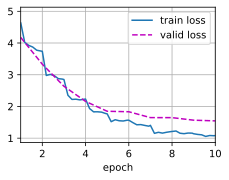

In [ ]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 10, 1e-4, 1e-4
lr_period, lr_decay, net = 2, 0.9, get_net(devices)
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

## **Classifying the Testing Set** and Submitting Results on Kaggle

섹션 14.13 `sec_kaggle_cifar10`의 마지막 단계와 마찬가지로, 결국 모든 라벨 데이터(검증 세트 포함)는 모델을 학습하고 테스트 세트를 분류하는 데 사용됩니다. 분류를 위해 custom output network를 사용합니다.


train loss 1.101
468.9 examples/sec on [device(type='cuda', index=0)]


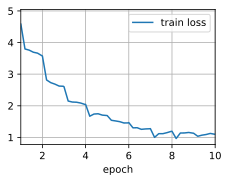

In [ ]:
net = get_net(devices)
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

preds = []
for data, label in test_iter:
    output = torch.nn.functional.softmax(net(data.to(devices[0])), dim=0)
    preds.extend(output.cpu().detach().numpy())
ids = sorted(os.listdir(
    os.path.join(data_dir, 'train_valid_test', 'test', 'unknown')))
with open('submission.csv', 'w') as f:
    f.write('id,' + ','.join(train_valid_ds.classes) + '\n')
    for i, output in zip(ids, preds):
        f.write(i.split('.')[0] + ',' + ','.join(
            [str(num) for num in output]) + '\n')

위의 코드는 섹션 5.7`sec_kaggle_house`에 설명된 것과 동일한 방법으로 Kaggle에 제출될 `submission.csv` 파일을 생성합니다.

## Summary

* ImageNet 데이터 세트의 이미지는 CIFAR-10 이미지보다 크기가 큽니다. 다른 데이터 세트의 작업들에 대해 이미지 어그멘테이션을 통해 수정할 수 있습니다.

* ImageNet 데이터 세트의 하위 집합을 분류하기 위해 전체 ImageNet 데이터 세트에서 사전학습된 모델을 활용하여 feature들을 추출하고 custom small-scale output network만 따로 훈련할 수 있습니다. 이렇게 하면 계산 시간과 메모리의 코스트가 절감됩니다.


## Exercises

1. When using the full Kaggle competition dataset, what results can you achieve when you increase `batch_size` (batch size) and `num_epochs` (number of epochs) while setting some other hyperparameters as `lr = 0.01`, `lr_period = 10`, and `lr_decay = 0.1`?
1. Do you get better results if you use a deeper pretrained model? How do you tune hyperparameters? Can you further improve the results?


[Discussions](https://discuss.d2l.ai/t/1481)
